In [1]:
from splitters import k_fold_edge_split, train_test_split_edges
from dataset_loader import load_dataframes
from model import Net
from utils import train_model, device_finder, train_model_on_folds, predict_edges, plot_layers_curve
from utils import train_model_on_folds_and_decode_all, predict_new_edges, predict_top_edges, plotter
import warnings
from graph_data_creater import create_graph_data_with_different_features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch_geometric.transforms import LocalDegreeProfile
import torch
from torch_geometric.data import Data
import numpy as np
# plotting shapes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# ignoring warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

final_dt_df, final_w2v_df, final_nv_df, final_fin_df, final_in_df, final_se_df, all_df = load_dataframes()
data_list = [data_dt, data_w2v, data_n2v, data_fin, data_in, data_se] = create_graph_data_with_different_features()

Epoch: 100, Train Loss: 0.429020, Val Auc: 0.977016, Test Auc: 0.974419


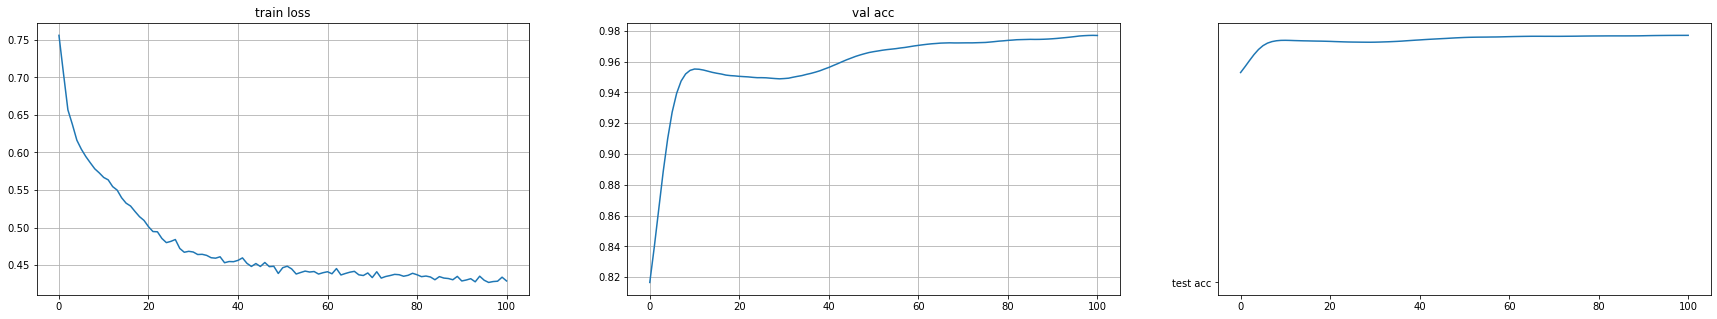

In [2]:
device = device_finder()
# number of channels
hid_channels = 128
out_channels = 64

all_t_list = []
all_v_list = []
all_te_list = []
all_prob_adj_list = []

# for data in data_list:
for data in [data_n2v]:
    # creating folds
    folds = k_fold_edge_split(data, only_upper_triangular_portion=False)
    in_channels = folds[0].num_features

    t_list = []
    v_list = []
    te_list = []
    prob_adj_list = []

    # for index in range(0, 6):
    for index in range(0, 1):
        train_loss, val_auc, test_auc, model, prob_adj = train_model_on_folds_and_decode_all(folds=folds, data=data,
                                    num_epochs=101, index=index, in_channels=in_channels, hid_channels=hid_channels, 
                                    out_channels=out_channels, device=device, model_class=Net, lr=0.0005, verbose=0)    
        t_list.append(train_loss[99])
        v_list.append(val_auc[99])
        te_list.append(test_auc[99])
        prob_adj_list.append(prob_adj)
    
    all_t_list.append(t_list)
    all_v_list.append(v_list)
    all_te_list.append(te_list)
    all_prob_adj_list.append(prob_adj_list)

In [8]:
all_new_pairs = predict_new_edges(all_prob_adj_list, data_n2v)

600 287
601 298
617 314
586 309
597 299


In [9]:
print(len(all_new_pairs))

65


In [ ]:
# model_names = ['GCN', 'SAGE', 'GAT', 'SAGE-GCN', 'GAT-SAGE', 'GCN-GAT']
# feature_names = ['dt', 'w2v', 'n2v', 'fin', 'ind', 'se', 'all']
# colors = ['black', 'gray', 'black', 'gray', 'black', 'gray', 'black']
# method_names = []
# all_test = []
# print(' '* 13, end='')
# for i, name in enumerate(feature_names):
#     if i % 6 != 5:
#         print(f'{name:<7}', end=' ')
#     else:
#         print(f'{name:<4}', end='')
# print()
# for i, model in enumerate(feature_names):
#     print(f'{model_names[i]:<10}', end='  ')
#     for j, feature in enumerate(model_names):
#         if j % 6 != 5:
#             print(format(all_te_list[i][j], '.3f'), end='   ')
#         else:
#             print(format(all_te_list[i][j], '.3f'), end='')
#         method_names.append(f'{feature} on {model}')
#         all_test.append(all_te_list[i][j])
#     if i % 6 == 5:
#         print('')
#     print()

# plotter(all_test, method_names, colors)

In [ ]:
all_edges = []
for edge in all_df.values:
    if list(edge) not in all_edges and [edge[1], edge[0]] not in all_edges:
        all_edges.append(list(edge))
        all_edges.append([edge[1], edge[0]])

# normalizing node2vec and word2vec

In [ ]:
# word2vec
df1 = final_w2v_df.iloc[:, :200].values
scaler = MinMaxScaler()
scaler.fit(df1)
scaled_data=scaler.transform(df1)
for i, col in enumerate(final_w2v_df.columns):
    if 'drugs' == col or 'drugsNo' == col:
        continue
    final_w2v_df[col] = scaled_data[:, i]
# nord2vec
df2 = final_nv_df.iloc[:, :128].values
scaler = MinMaxScaler()
scaler.fit(df2)
scaled_data=scaler.transform(df2)
for i, col in enumerate(final_nv_df.columns):
    if 'drugs' == col or 'drugsNo' == col:
        continue
    final_nv_df[col] = scaled_data[:, i]


# Loading all features as graph nodes features

In [ ]:
df_list = [final_dt_df, final_w2v_df, final_nv_df, final_fin_df, final_in_df, final_se_df]

In [ ]:
x_in = final_in_df.iloc[:, :128]
x_in = np.array(x_in, dtype=np.float32)
nodes_list = list()
nodes_dict = dict()
###################################################
drug_names = []
for drug in list(final_in_df.drugs):
    count = 0
    for df in df_list:
        if drug in list(df.drugs):
            count += 1
    if count == len(df_list):
        drug_names.append(drug)

count = 0
for d in final_in_df.drugs.values:
    if d in drug_names:
        nodes_dict[d] = count
        count+=1
        nodes_list.append(d)
print(len(drug_names))
##############################################
str_edges = []
for row in all_df.values:
    d1 = row[0]
    d2 = row[1]
    edge = [d1, d2]
    if edge not in str_edges and [edge[1], edge[0]] not in str_edges and edge[0] in drug_names and edge[1] in drug_names:
        str_edges.append(list(edge))
        str_edges.append([edge[1], edge[0]])  
print(len(str_edges))  

edges = []
for edge in str_edges:
    d1 = nodes_dict[edge[0]]
    d2 = nodes_dict[edge[1]]
    edges.append([d1, d2])
print(len(edges))
edges = torch.from_numpy(np.array(edges))
print(edges)
##########################################################
def check_all(drug, drug_names):
    if drug in drug_names:
        return True
    else:
        return False

drug_numbers = []
drug_features = []

for drug in list(nodes_dict.keys()):
    features = []
    if check_all(drug, drug_names):
        for i, df in enumerate(df_list):
            # print(df.shape)
            a = df[df.drugs == drug].iloc[:, :(df.shape[1]-2)].values.squeeze()
            a = a[:a.shape[0]]
            features.append(np.array(a, dtype=np.float32))
        drug_features.append(features)
        drug_numbers.append(drug)

print(len(drug_features))

all_drug_features = []
for i in range(len(drug_features)):
    l = []
    for j in range(len(drug_features[i])):
        z = drug_features[i][j]
        for k in z:
            l.append(k)
    all_drug_features.append(np.array(l, dtype=np.float32))
all_drug_features = np.array(all_drug_features)
all_drug_features = torch.from_numpy(all_drug_features)

print(all_drug_features.shape)

data = Data(x=all_drug_features, edge_index=edges.T)

In [ ]:
folds = k_fold_edge_split(data, only_upper_triangular_portion=True, val_ratio=0.2, test_ratio=0.2)
folds.append(data)

device = device_finder()

in_channels = folds[0].num_features
hid_channels = 128
out_channels = 64

t_list = []
v_list = []
te_list = []

for index in range(0, 6):
    train_loss, val_acc, test_acc, model, val_aupr, test_aupr, val_fscore, test_fscore = train_model_on_folds(folds=folds,
    num_epochs=101, index=index, in_channels=in_channels, hid_channels=hid_channels, out_channels=out_channels, 
    device=device, model_class=Net, lr=0.0005, verbose=0)
    
    t_list.append(train_loss)
    v_list.append(val_acc)
    te_list.append(test_acc)

all_te_list.append(te_list)

In [ ]:
model_names = ['GCN', 'SAGE', 'GAT', 'SAGE-GCN', 'GAT-SAGE', 'GCN-GAT']
feature_names = ['dt', 'w2v', 'n2v', 'fin', 'ind', 'se', 'all']
colors = ['black', 'gray', 'black', 'gray', 'black', 'gray', 'black']
method_names = []
all_test = []
print(' '* 13, end='')
for i, name in enumerate(feature_names):
    if i % 6 != 5:
        print(f'{name:<7}', end=' ')
    else:
        print(f'{name:<4}', end='')
print()
for i, model in enumerate(feature_names):
    print(f'{model_names[i]:<10}', end='  ')
    for j, feature in enumerate(model_names):
        if j % 6 != 5:
            print(format(all_te_list[i][j], '.3f'), end='   ')
        else:
            print(format(all_te_list[i][j], '.3f'), end='')
        method_names.append(f'{feature} on {model}')
        all_test.append(all_te_list[i][j])
    if i % 6 == 5:
        print('')
    print()

plotter(all_test, method_names, colors)

In [ ]:
#              dt      w2v     n2v     fin     ind     se  
# GCN         0.924   0.854   0.773   0.895   0.802   0.860
# SAGE        0.946   0.914   0.855   0.936   0.904   0.935
# GAT         0.973   0.936   0.888   0.963   0.908   0.965
# SAGE-GCN    0.894   0.855   0.780   0.871   0.788   0.840
# GAT-SAGE    0.944   0.897   0.715   0.927   0.829   0.917
# GCN-GAT     0.942   0.914   0.798   0.932   0.857   0.909


# scores = [0.924, 0.854, 0.773, 0.895, 0.802, 0.860,
#         0.946, 0.914, 0.855, 0.936, 0.904, 0.935,
#         0.973, 0.936, 0.888, 0.963, 0.908, 0.965,
#         0.894, 0.855, 0.780, 0.871, 0.788, 0.840,
#         0.944, 0.897, 0.715, 0.927, 0.829, 0.917,
#         0.942, 0.914, 0.798, 0.932, 0.857, 0.909,
#         0.937, 0.918, 0.846, 0.936, 0.879, 0.909]

In [395]:
scores = [0.924, 0.854, 0.773, 0.895, 0.802, 0.860,
0.946, 0.914, 0.855, 0.936, 0.904, 0.935,
0.973, 0.936, 0.888, 0.963, 0.908, 0.965,
0.894, 0.855, 0.780, 0.871, 0.788, 0.840,
0.944, 0.897, 0.715, 0.927, 0.829, 0.917,
0.942, 0.914, 0.798, 0.932, 0.857, 0.909,
0.937, 0.918, 0.846, 0.936, 0.879, 0.909]

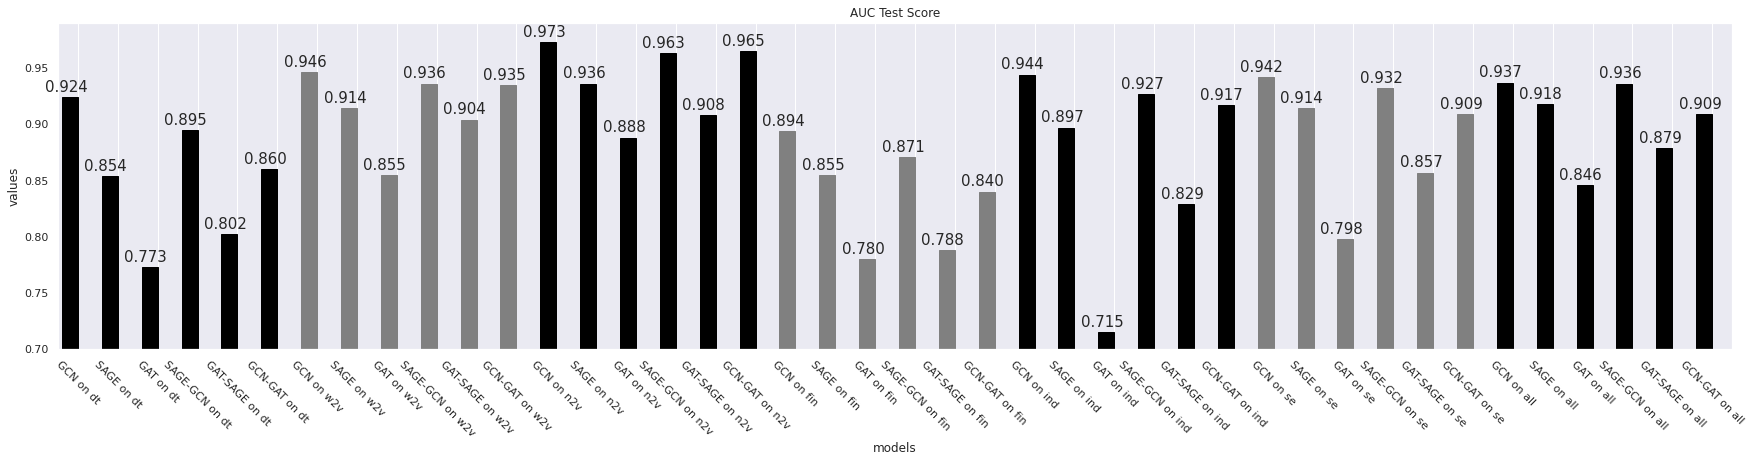

In [399]:
model_names = ['GCN', 'SAGE', 'GAT', 'SAGE-GCN', 'GAT-SAGE', 'GCN-GAT']
feature_names = ['dt', 'w2v', 'n2v', 'fin', 'ind', 'se', 'all']
colors = ['black', 'gray', 'black', 'gray', 'black', 'gray', 'black']
method_names = []
all_test = []
# print(' '* 13, end='')
# for i, name in enumerate(feature_names):
#     if i % 6 != 5:
#         print(f'{name:<7}', end=' ')
#     else:
#         print(f'{name:<4}', end='')
# print()
for i, model in enumerate(feature_names):
    # print(f'{model_names[i]:<10}', end='  ')
    for j, feature in enumerate(model_names):
    #     if j % 6 != 5:
    #         print(format(all_te_list[i][j], '.3f'), end='   ')
    #     else:
    #         print(format(all_te_list[i][j], '.3f'), end='')
        method_names.append(f'{feature} on {model}')
    #     all_test.append(all_te_list[i][j])
    # if i % 6 == 5:
    #     print('')
    # print()

plotter(scores, method_names, colors)

In [422]:
scores = np.array(scores)
scores = np.reshape(scores, (7, 6))
print(scores)

[[0.924 0.854 0.773 0.895 0.802 0.86 ]
 [0.946 0.914 0.855 0.936 0.904 0.935]
 [0.973 0.936 0.888 0.963 0.908 0.965]
 [0.894 0.855 0.78  0.871 0.788 0.84 ]
 [0.944 0.897 0.715 0.927 0.829 0.917]
 [0.942 0.914 0.798 0.932 0.857 0.909]
 [0.937 0.918 0.846 0.936 0.879 0.909]]


(6,)
(7,)

['GCN', 'SAGE', 'GAT', 'SAGE-GCN', 'GAT-SAGE', 'GCN-GAT']
['dt', 'w2v', 'n2v', 'fin', 'ind', 'se', 'all']


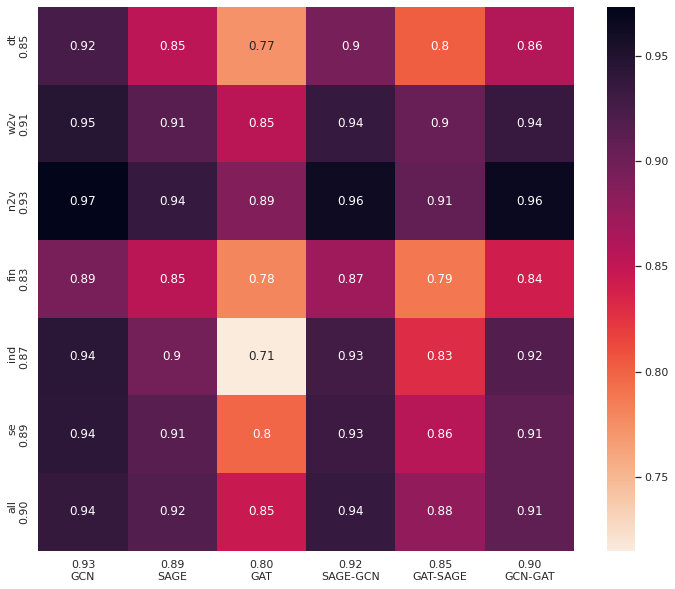

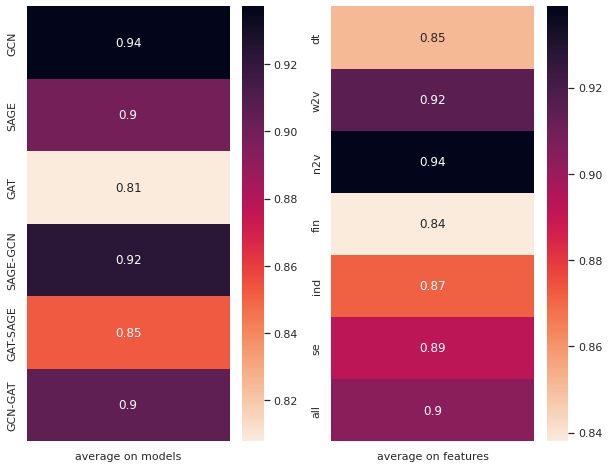

In [464]:
model_names = ['GCN', 'SAGE', 'GAT', 'SAGE-GCN', 'GAT-SAGE', 'GCN-GAT']
m_names = model_names[:]
feature_names = ['dt', 'w2v', 'n2v', 'fin', 'ind', 'se', 'all']
f_names = feature_names[:]

ave_col = np.average(scores, axis=0)
ave_row = np.average(scores, axis=1)

print(ave_col.shape)
print(ave_row.shape)
print()
for i in range(len(model_names)):
    m_names[i] = f'{str(ave_col[i])[:4]}\n{model_names[i]}'

for i in range(len(feature_names)):
    f_names[i] = f'{feature_names[i]}\n{str(ave_row[i])[:4]}'

print(model_names)
print(feature_names)

import seaborn as sns; sns.set_theme()

heat_scores = [[0.924, 0.854, 0.773, 0.895, 0.802, 0.860],
[0.946, 0.914, 0.855, 0.936, 0.904, 0.935],
[0.973, 0.936, 0.888, 0.963, 0.908, 0.965],
[0.894, 0.855, 0.780, 0.871, 0.788, 0.840],
[0.944, 0.897, 0.715, 0.927, 0.829, 0.917],
[0.942, 0.914, 0.798, 0.932, 0.857, 0.909],
[0.937, 0.918, 0.846, 0.936, 0.879, 0.909]]

cmap = sns.cm.rocket_r

plt.figure(figsize=(12, 10))
ax = sns.heatmap(heat_scores, annot=True, cmap=cmap)
ax.set_xticklabels(m_names)
ax.set_yticklabels(f_names)
plt.show()

############################################

cmap = sns.cm.rocket_r
plt.figure(figsize=(10, 8))

plt.subplot(121)
ave_col = np.reshape(ave_col, (ave_col.shape[0], 1))
ax = sns.heatmap(ave_col, annot=True, cmap=cmap)
ax.set_xticklabels(['average on models'])
ax.set_yticklabels(model_names)
############################
plt.subplot(122)
ave_row = np.reshape(ave_row, (ave_row.shape[0], 1))
ax = sns.heatmap(ave_row, annot=True, cmap=cmap)
ax.set_xticklabels(['average on features'])
ax.set_yticklabels(feature_names)
plt.show()


In [466]:
heat_scores = [[0.924, 0.854, 0.773, 0.895, 0.802, 0.860],
[0.946, 0.914, 0.855, 0.936, 0.904, 0.935],
[0.973, 0.936, 0.888, 0.963, 0.908, 0.965],
[0.894, 0.855, 0.780, 0.871, 0.788, 0.840],
[0.944, 0.897, 0.715, 0.927, 0.829, 0.917],
[0.942, 0.914, 0.798, 0.932, 0.857, 0.909],
[0.937, 0.918, 0.846, 0.936, 0.879, 0.909]]

sum = 0
for i in range(len(heat_scores)):
    for j in range(len(heat_scores[0])):
        sum += heat_scores[i][j]
print(sum / 42)

0.8872619047619046


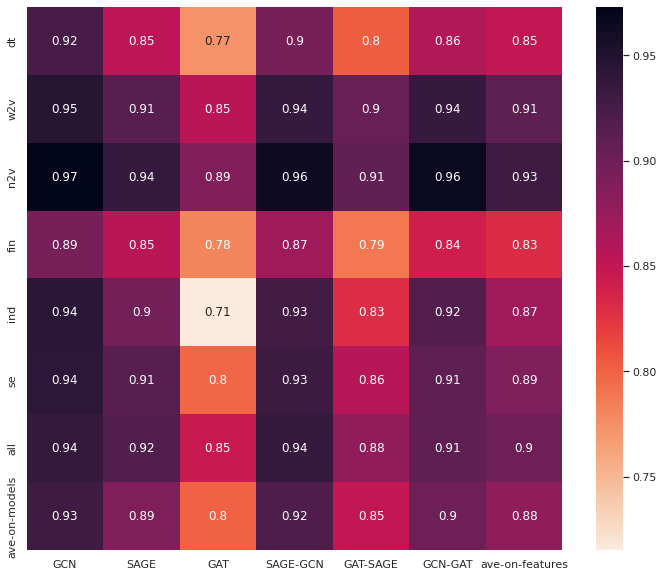

In [468]:
model_names = ['GCN', 'SAGE', 'GAT', 'SAGE-GCN', 'GAT-SAGE', 'GCN-GAT', 'ave-on-features']
m_names = model_names[:]
feature_names = ['dt', 'w2v', 'n2v', 'fin', 'ind', 'se', 'all', 'ave-on-models']
f_names = feature_names[:]

heat_scores = [[0.924, 0.854, 0.773, 0.895, 0.802, 0.860, 0.85],
[0.946, 0.914, 0.855, 0.936, 0.904, 0.935, 0.91],
[0.973, 0.936, 0.888, 0.963, 0.908, 0.965, 0.93],
[0.894, 0.855, 0.780, 0.871, 0.788, 0.840, 0.83],
[0.944, 0.897, 0.715, 0.927, 0.829, 0.917, 0.87],
[0.942, 0.914, 0.798, 0.932, 0.857, 0.909, 0.89],
[0.937, 0.918, 0.846, 0.936, 0.879, 0.909, 0.90],
[0.93,  0.89,  0.80,  0.92,  0.85,  0.90,  0.88]]

cmap = sns.cm.rocket_r

plt.figure(figsize=(12, 10))
ax = sns.heatmap(heat_scores, annot=True, cmap=cmap)
ax.set_xticklabels(m_names)
ax.set_yticklabels(f_names)
plt.show()